## Introduction
The dataset is used for this competition is synthetic, but based on a real dataset and generated using a CTGAN. The original dataset deals with predicting the biological response of molecules given various chemical properties. Although the features are anonymized, they have properties relating to real-world features. 

Submissions are evaluated on **area under the ROC Curve** between the predicted probability and target.

## Imports

In [1]:
import os
import gc
gc.enable()
import time
import random
import warnings

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn import tree
from sklearn import impute
from sklearn import metrics
from sklearn import ensemble
from sklearn import linear_model
from sklearn import decomposition
from sklearn import preprocessing
from sklearn import model_selection

warnings.filterwarnings('ignore')

SEED = 42
np.random.seed(SEED)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('float_format', '{:f}'.format)

sns.set_style("darkgrid")
mpl.rcParams['figure.dpi'] = 600
%matplotlib inline

## Data

In [2]:
train_df = pd.read_csv('../data/train.csv')
test_df = pd.read_csv('../data/test.csv')

print('Quick view of training data: ')
train_df.head()

Quick view of training data: 


,id,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30,f31,f32,f33,f34,f35,f36,f37,f38,f39,f40,f41,f42,f43,f44,f45,f46,f47,f48,f49,f50,f51,f52,f53,f54,f55,f56,f57,f58,f59,f60,f61,f62,f63,f64,f65,f66,f67,f68,f69,f70,f71,f72,f73,f74,f75,f76,f77,f78,f79,f80,f81,f82,f83,f84,f85,f86,f87,f88,f89,f90,f91,f92,f93,f94,f95,f96,f97,f98,f99,f100,f101,f102,f103,f104,f105,f106,f107,f108,f109,f110,f111,f112,f113,f114,f115,f116,f117,f118,f119,f120,f121,f122,f123,f124,f125,f126,f127,f128,f129,f130,f131,f132,f133,f134,f135,f136,f137,f138,f139,f140,f141,f142,f143,f144,f145,f146,f147,f148,f149,f150,f151,f152,f153,f154,f155,f156,f157,f158,f159,f160,f161,f162,f163,f164,f165,f166,f167,f168,f169,f170,f171,f172,f173,f174,f175,f176,f177,f178,f179,f180,f181,f182,f183,f184,f185,f186,f187,f188,f189,f190,f191,f192,f193,f194,f195,f196,f197,f198,f199,f200,f201,f202,f203,f204,f205,f206,f207,f208,f209,f210,f211,f212,f213,f214,f215,f216,f217,f218,f219,f220,f221,f222,f223,f224,f225,f226,f227,f228,f229,f230,f231,f232,f233,f234,f235,f236,f237,f238,f239,f240,f241,f242,f243,f244,f245,f246,f247,f248,f249,f250,f251,f252,f253,f254,f255,f256,f257,f258,f259,f260,f261,f262,f263,f264,f265,f266,f267,f268,f269,f270,f271,f272,f273,f274,f275,f276,f277,f278,f279,f280,f281,f282,f283,f284,target
0,0,0.205979,0.410993,0.176775,0.223581,0.423543,0.476140,0.413590,0.612021,0.534873,0.147295,0.026177,0.106613,0.200924,0.713191,0.155750,0.557335,0.341702,0.285720,0.230396,0.203957,0.509588,0.706972,1,0.007793,0.247765,0.263750,0.259555,0.231730,0.138379,0.197824,0.054392,0.194153,0.281500,0.034818,0.025334,0.114432,0.139203,0.246157,0.251371,0.701423,0.301182,0.193924,0.267497,0,0.193430,0.238630,0.154770,0.249857,0.210685,0.406662,0.214810,0.258668,0.377518,0.192042,0.340855,0.199660,0.264074,0.205550,0.075109,0.205688,0.178962,0.245008,0.519336,0.306419,0.127139,0.367479,0.236380,0.195694,0.013195,0.199588,0.283367,0.168824,0.004855,0.117723,0.257688,0.197262,0.211452,0.372637,0.198157,0.689970,0.449955,0.713110,0.212041,0.183619,0.288667,0.648678,0.600398,0.223267,0.590163,0.248847,0.795641,0.139932,0.618696,0.639142,0.008549,0.559151,0.573640,0.138808,0.499156,0.112203,0.181498,0.165887,0.093171,0.106952,0.127861,0.250924,0.501673,0.036740,0.111361,0.075918,0.019444,0.250760,0.465093,0.087502,0.004185,0.195936,0.166389,0.171328,0.146014,0.199232,0.133999,0.168191,0.010242,0.294490,0.012977,0.003969,0.013739,0.040076,0.170711,0.250246,0.195538,0.708556,0.448925,0.550352,0.217984,0.751629,0.822459,0.186298,0.024197,0.044097,0.078943,0.181147,0.022591,0.576712,0.406843,0.510578,0.799434,0.651125,0.460708,0.636714,0.350704,0.872989,0.007751,0.017103,0.019875,0.203042,0.864594,0.595877,0.542969,0.990250,0.020373,0.006238,0.011040,0.006019,0.407014,0.080140,0.013502,0.144265,0.007229,0.003256,0.014556,0.123806,0.133871,0.011531,0.010250,0.253750,0.090162,0.147857,0.303087,0.112764,0.104344,0.168583,0.011342,0.239028,0.008018,0.167653,0.217342,0.184178,0.179060,0.078009,0.135768,0.006534,0.009832,0.013317,0.390079,0.004801,0.056600,0.114139,0.012599,0.014818,0.446073,0.216079,0.152113,0.111237,0.170896,0.190477,0.011936,0.005227,0.429740,0.013060,0.199369,0.258410,0.208863,0.129545,0.006978,0.012948,0.049466,0.008804,0.114205,0.119683,0.191210,0.169976,0.188199,0.355674,0.013164,0.304878,0.007213,0.011277,0.083186,0.010624,0.031199,0.200306,0.195791,0.203470,0.036314,0.157711,0.199117,0.007444,0.189048,0.202540,0.273267,0.167211,1,0,1,1,1,0,0,0,0,0,0,1,0,1,1,0,0,0,1,0,0,1,1,0,0,0,1,1,0,1,0,1,1,0,0,1,0,0,0,0,0,0,0,1
1,1,0.181004,0.473119,0.011734,0.213657,0.619678,0.441593,0.230407,0.686013,0.281971,0.238509,0.493411,0.107277,0.231828,0.457150,0.395200,0.617088,0.459358,0.209225,0.201098,0.199383,0.366578,0.585788,1,0.285311,0.400367,0.162493,0.249365,0.141160,0.133688,0.247906,0.139251,0.216444,0.109674,0.033018,0.017458,0.189336,0.168785,0.184251,0.202753,0.218451,0.324364,0.255499,0.287433,0,0.821982,0.284351,0.177537,0.207

In [4]:
sample = train_df.sample(100000)
sample.to_csv('../data/train_sample.csv')

In [5]:
sample.shape

(100000, 287)

In [5]:
TARGET = 'target'
FEATURES = [col for col in train_df.columns if col not in ['id', TARGET]]
print(f'Training data:\n\t Number of rows: {train_df.shape[0]}, Number of columns: {train_df.shape[1]}')
print(f'Testing data:\n\t Number of rows: {test_df.shape[0]}, Number of columns: {test_df.shape[1]}')

Training data:
	 Number of rows: 1000000, Number of columns: 287
Testing data:
	 Number of rows: 500000, Number of columns: 286


In [6]:
print('Basic statistics of training data:')
train_df[FEATURES+[TARGET]].describe()

Basic statistics of training data:


,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30,f31,f32,f33,f34,f35,f36,f37,f38,f39,f40,f41,f42,f43,f44,f45,f46,f47,f48,f49,f50,f51,f52,f53,f54,f55,f56,f57,f58,f59,f60,f61,f62,f63,f64,f65,f66,f67,f68,f69,f70,f71,f72,f73,f74,f75,f76,f77,f78,f79,f80,f81,f82,f83,f84,f85,f86,f87,f88,f89,f90,f91,f92,f93,f94,f95,f96,f97,f98,f99,f100,f101,f102,f103,f104,f105,f106,f107,f108,f109,f110,f111,f112,f113,f114,f115,f116,f117,f118,f119,f120,f121,f122,f123,f124,f125,f126,f127,f128,f129,f130,f131,f132,f133,f134,f135,f136,f137,f138,f139,f140,f141,f142,f143,f144,f145,f146,f147,f148,f149,f150,f151,f152,f153,f154,f155,f156,f157,f158,f159,f160,f161,f162,f163,f164,f165,f166,f167,f168,f169,f170,f171,f172,f173,f174,f175,f176,f177,f178,f179,f180,f181,f182,f183,f184,f185,f186,f187,f188,f189,f190,f191,f192,f193,f194,f195,f196,f197,f198,f199,f200,f201,f202,f203,f204,f205,f206,f207,f208,f209,f210,f211,f212,f213,f214,f215,f216,f217,f218,f219,f220,f221,f222,f223,f224,f225,f226,f227,f228,f229,f230,f231,f232,f233,f234,f235,f236,f237,f238,f239,f240,f241,f242,f243,f244,f245,f246,f247,f248,f249,f250,f251,f252,f253,f254,f255,f256,f257,f258,f259,f260,f261,f262,f263,f264,f265,f266,f267,f268,f269,f270,f271,f272,f273,f274,f275,f276,f277,f278,f279,f280,f281,f282,f283,f284,target
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1

In [7]:
print('Basic statistics of testing data:')
test_df[FEATURES].describe()

Basic statistics of testing data:


,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30,f31,f32,f33,f34,f35,f36,f37,f38,f39,f40,f41,f42,f43,f44,f45,f46,f47,f48,f49,f50,f51,f52,f53,f54,f55,f56,f57,f58,f59,f60,f61,f62,f63,f64,f65,f66,f67,f68,f69,f70,f71,f72,f73,f74,f75,f76,f77,f78,f79,f80,f81,f82,f83,f84,f85,f86,f87,f88,f89,f90,f91,f92,f93,f94,f95,f96,f97,f98,f99,f100,f101,f102,f103,f104,f105,f106,f107,f108,f109,f110,f111,f112,f113,f114,f115,f116,f117,f118,f119,f120,f121,f122,f123,f124,f125,f126,f127,f128,f129,f130,f131,f132,f133,f134,f135,f136,f137,f138,f139,f140,f141,f142,f143,f144,f145,f146,f147,f148,f149,f150,f151,f152,f153,f154,f155,f156,f157,f158,f159,f160,f161,f162,f163,f164,f165,f166,f167,f168,f169,f170,f171,f172,f173,f174,f175,f176,f177,f178,f179,f180,f181,f182,f183,f184,f185,f186,f187,f188,f189,f190,f191,f192,f193,f194,f195,f196,f197,f198,f199,f200,f201,f202,f203,f204,f205,f206,f207,f208,f209,f210,f211,f212,f213,f214,f215,f216,f217,f218,f219,f220,f221,f222,f223,f224,f225,f226,f227,f228,f229,f230,f231,f232,f233,f234,f235,f236,f237,f238,f239,f240,f241,f242,f243,f244,f245,f246,f247,f248,f249,f250,f251,f252,f253,f254,f255,f256,f257,f258,f259,f260,f261,f262,f263,f264,f265,f266,f267,f268,f269,f270,f271,f272,f273,f274,f275,f276,f277,f278,f279,f280,f281,f282,f283,f284
count,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,5000

In [8]:
print(f'Number of missing values in training data: {train_df.isna().sum().sum()}')
print(f'Number of missing values in testing data: {test_df.isna().sum().sum()}')

Number of missing values in training data: 0
Number of missing values in testing data: 0


## EDA

Total number of features: 285
Number of categorical features: 45
Number of continuos features: 240


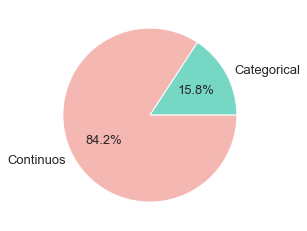

In [9]:
df = pd.concat([train_df[FEATURES], test_df[FEATURES]], axis=0)

cat_features = [col for col in FEATURES if df[col].nunique() < 25]
cont_features = [col for col in FEATURES if df[col].nunique() >= 25]

del df
print(f'Total number of features: {len(FEATURES)}')
print(f'Number of categorical features: {len(cat_features)}')
print(f'Number of continuos features: {len(cont_features)}')

plt.pie([len(cat_features), len(cont_features)], 
        labels=['Categorical', 'Continuos'],
        colors=['#76D7C4', '#F5B7B1'],
        textprops={'fontsize': 13},
        autopct='%1.1f%%')
plt.show()

Feature distribution of continous features: 


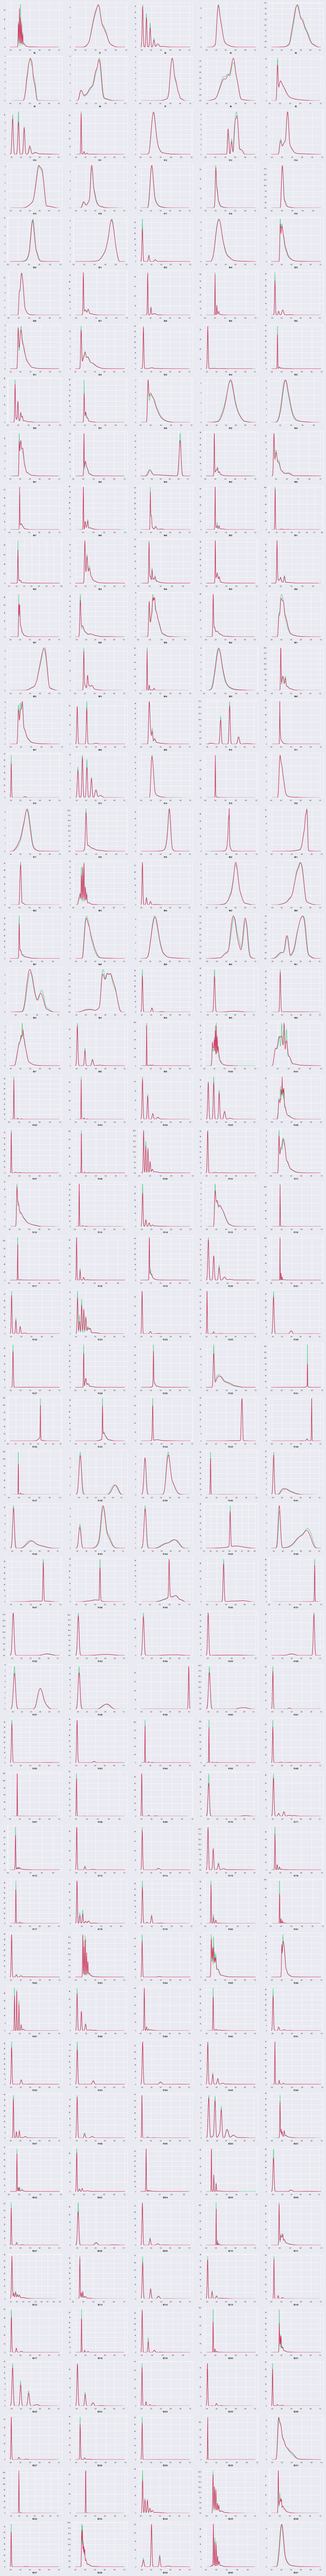

In [10]:
print("Feature distribution of continous features: ")
ncols = 5
nrows = int(len(cont_features) / ncols + (len(FEATURES) % ncols > 0))

fig, axes = plt.subplots(nrows, ncols, figsize=(18, 150), facecolor='#EAEAF2')

for r in range(nrows):
    for c in range(ncols):
        col = cont_features[r*ncols+c]
        sns.kdeplot(x=train_df[col], ax=axes[r, c], color='#58D68D', label='Train data')
        sns.kdeplot(x=test_df[col], ax=axes[r, c], color='#DE3163', label='Test data')
        axes[r, c].set_ylabel('')
        axes[r, c].set_xlabel(col, fontsize=8, fontweight='bold')
        axes[r, c].tick_params(labelsize=5, width=0.5)
        axes[r, c].xaxis.offsetText.set_fontsize(4)
        axes[r, c].yaxis.offsetText.set_fontsize(4)
plt.show()

Feature distribution of categorical features: 


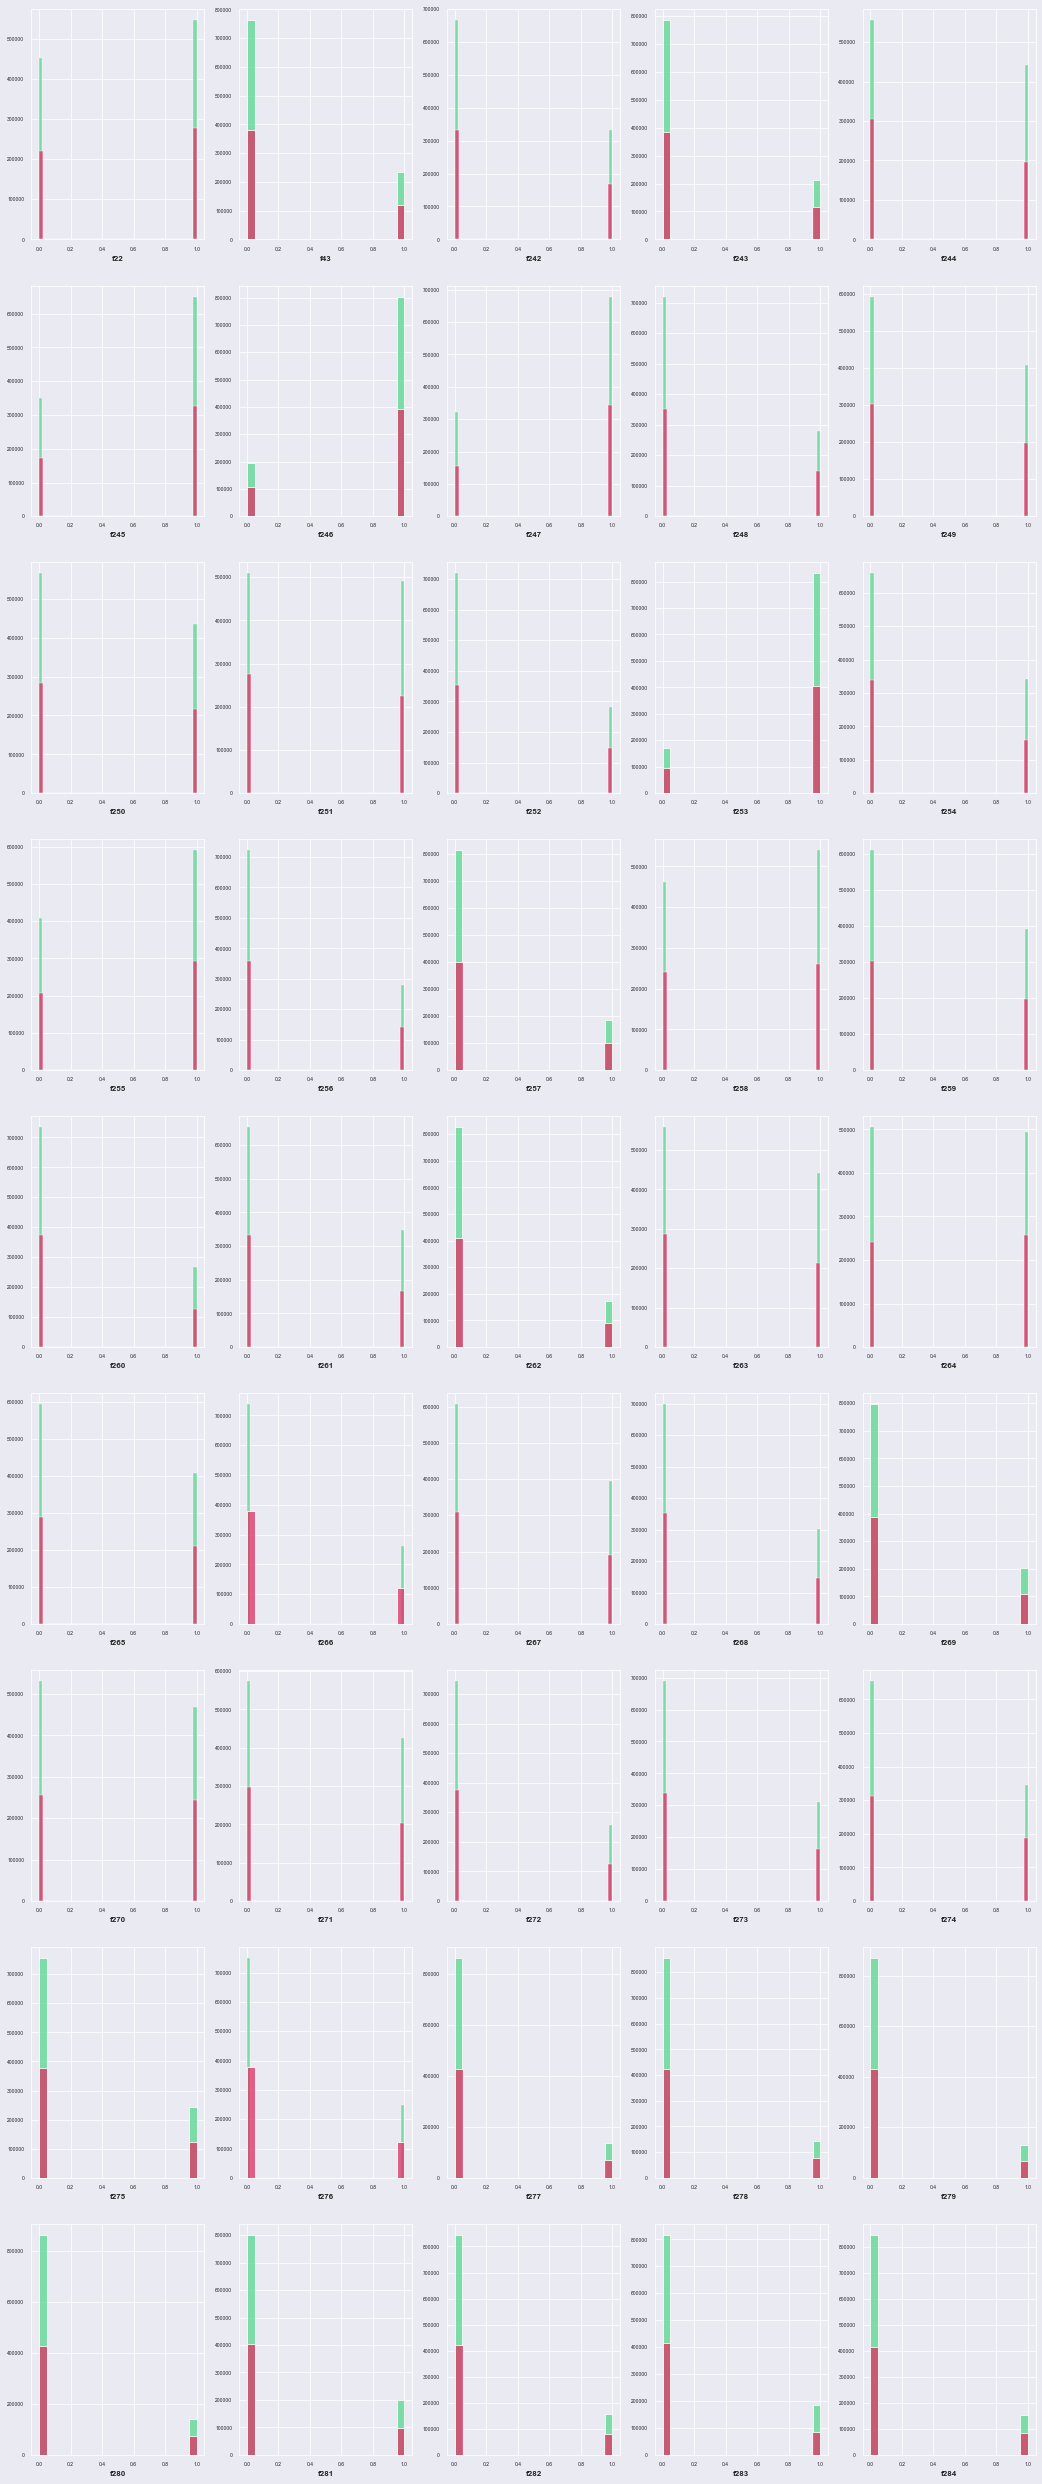

In [11]:
print("Feature distribution of categorical features: ")
ncols = 5
nrows = int(len(cat_features) / ncols + (len(FEATURES) % ncols > 0))

fig, axes = plt.subplots(nrows, ncols, figsize=(18, 45), facecolor='#EAEAF2')

for r in range(nrows):
    for c in range(ncols):
        col = cat_features[r*ncols+c]
        sns.histplot(x=train_df[col], ax=axes[r, c], color='#58D68D', label='Train data')
        sns.histplot(x=test_df[col], ax=axes[r, c], color='#DE3163', label='Test data')
        axes[r, c].set_ylabel('')
        axes[r, c].set_xlabel(col, fontsize=8, fontweight='bold')
        axes[r, c].tick_params(labelsize=5, width=0.5)
        axes[r, c].xaxis.offsetText.set_fontsize(4)
        axes[r, c].yaxis.offsetText.set_fontsize(4)
plt.show()

Looks like all the categorical features are binary.

Target Distribution: 


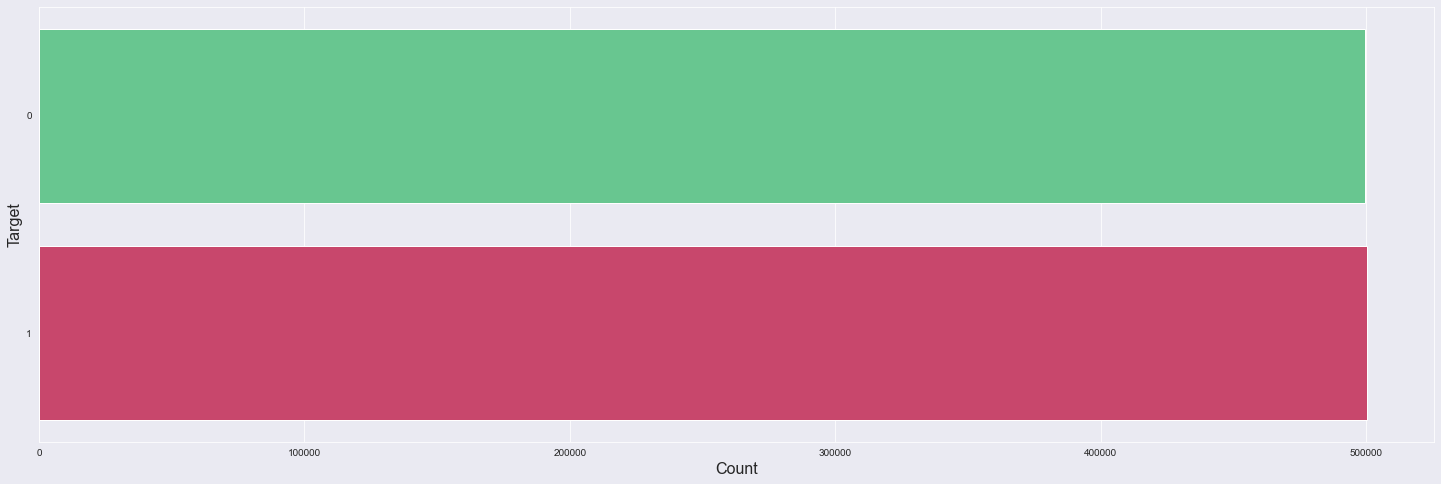

In [12]:
print("Target Distribution: ")

target_df = pd.DataFrame(train_df[TARGET].value_counts()).reset_index()
target_df.columns = [TARGET, 'count']

fig, ax = plt.subplots(1, 1, figsize=(25, 8), facecolor='#EAEAF2')
sns.barplot(y=TARGET, x='count', data=target_df, palette=['#58D68D', '#DE3163'], ax=ax, orient='h')
ax.set_xlabel('Count', fontsize=16)
ax.set_ylabel('Target', fontsize=16)
plt.show()

## Feature Engineering

In [13]:
train_df["mean"] = train_df[FEATURES].mean(axis=1)
train_df["std"] = train_df[FEATURES].std(axis=1)
train_df["min"] = train_df[FEATURES].min(axis=1)
train_df["max"] = train_df[FEATURES].max(axis=1)

test_df["mean"] = test_df[FEATURES].mean(axis=1)
test_df["std"] = test_df[FEATURES].std(axis=1)
test_df["min"] = test_df[FEATURES].min(axis=1)
test_df["max"] = test_df[FEATURES].max(axis=1)

FEATURES.extend(['mean', 'max', 'min', 'max'])

## Utils

In [14]:
def format_time(seconds):
    """
    Formates time in human readable form

    Args:
        seconds: seconds passed in a process
    Return:
        formatted string in form of MM:SS or HH:MM:SS
    """
    h = int(seconds // 3600)
    m = int((seconds % 3600) // 60)
    s = int(seconds % 60)

    result = ''

    if h > 0:
        if h < 10:
            h = '0' + str(h)
        else:
            h = str(h)
        h += ' Hr'
        result += h
        result += ' '
    
    if m > 0:
        if m < 10:
            m = '0' + str(m)
        else:
            m = str(m)
        m += ' min'
        result += m
        result += ' '

    if s < 10:
        s = '0' + str(s)
    else:
        s = str(s)
    s += ' sec'
    result += s
    
    return result

INT8_MIN    = np.iinfo(np.int8).min
INT8_MAX    = np.iinfo(np.int8).max
INT16_MIN   = np.iinfo(np.int16).min
INT16_MAX   = np.iinfo(np.int16).max
INT32_MIN   = np.iinfo(np.int32).min
INT32_MAX   = np.iinfo(np.int32).max

FLOAT16_MIN = np.finfo(np.float16).min
FLOAT16_MAX = np.finfo(np.float16).max
FLOAT32_MIN = np.finfo(np.float32).min
FLOAT32_MAX = np.finfo(np.float32).max


def memory_usage(data, detail=1):
    if detail:
        display(data.memory_usage())
    memory = data.memory_usage().sum() / (1024*1024)
    print("Memory usage : {0:.2f}MB".format(memory))
    return memory


def compress_dataset(data):
    memory_before_compress = memory_usage(data, 0)
    print()
    length_interval      = 50
    length_float_decimal = 4

    print('='*length_interval)
    for col in data.columns:
        col_dtype = data[col][:100].dtype

        if col_dtype != 'object':
            print("Name: {0:24s} Type: {1}".format(col, col_dtype))
            col_series = data[col]
            col_min = col_series.min()
            col_max = col_series.max()

            if col_dtype == 'float64':
                print(" variable min: {0:15s} max: {1:15s}".format(str(np.round(col_min, length_float_decimal)), str(np.round(col_max, length_float_decimal))))
                if (col_min > FLOAT16_MIN) and (col_max < FLOAT16_MAX):
                    data[col] = data[col].astype(np.float16)
                    print("  float16 min: {0:15s} max: {1:15s}".format(str(FLOAT16_MIN), str(FLOAT16_MAX)))
                    print("compress float64 --> float16")
                elif (col_min > FLOAT32_MIN) and (col_max < FLOAT32_MAX):
                    data[col] = data[col].astype(np.float32)
                    print("  float32 min: {0:15s} max: {1:15s}".format(str(FLOAT32_MIN), str(FLOAT32_MAX)))
                    print("compress float64 --> float32")
                else:
                    pass
                memory_after_compress = memory_usage(data, 0)
                print("Compress Rate: [{0:.2%}]".format((memory_before_compress-memory_after_compress) / memory_before_compress))
                print('='*length_interval)

            if col_dtype == 'int64':
                print(" variable min: {0:15s} max: {1:15s}".format(str(col_min), str(col_max)))
                type_flag = 64
                if (col_min > INT8_MIN/2) and (col_max < INT8_MAX/2):
                    type_flag = 8
                    data[col] = data[col].astype(np.int8)
                    print("     int8 min: {0:15s} max: {1:15s}".format(str(INT8_MIN), str(INT8_MAX)))
                elif (col_min > INT16_MIN) and (col_max < INT16_MAX):
                    type_flag = 16
                    data[col] = data[col].astype(np.int16)
                    print("    int16 min: {0:15s} max: {1:15s}".format(str(INT16_MIN), str(INT16_MAX)))
                elif (col_min > INT32_MIN) and (col_max < INT32_MAX):
                    type_flag = 32
                    data[col] = data[col].astype(np.int32)
                    print("    int32 min: {0:15s} max: {1:15s}".format(str(INT32_MIN), str(INT32_MAX)))
                    type_flag = 1
                else:
                    pass
                memory_after_compress = memory_usage(data, 0)
                print("Compress Rate: [{0:.2%}]".format((memory_before_compress-memory_after_compress) / memory_before_compress))
                if type_flag == 32:
                    print("compress (int64) ==> (int32)")
                elif type_flag == 16:
                    print("compress (int64) ==> (int16)")
                else:
                    print("compress (int64) ==> (int8)")
                print('='*length_interval)

    print()
    memory_after_compress = memory_usage(data, 0)
    print("Compress Rate: [{0:.2%}]".format((memory_before_compress-memory_after_compress) / memory_before_compress))
    
    return data


## Data preprocessing

In [15]:
train_df = compress_dataset(train_df)
test_df = compress_dataset(test_df)

Memory usage : 2220.15MB

Name: id                       Type: int64
 variable min: 0               max: 999999         
    int32 min: -2147483648     max: 2147483647     
Memory usage : 2216.34MB
Compress Rate: [0.17%]
compress (int64) ==> (int8)
Name: f0                       Type: float64
 variable min: 0.0418          max: 1.0            
  float16 min: -65500.0        max: 65500.0        
compress float64 --> float16
Memory usage : 2210.62MB
Compress Rate: [0.43%]
Name: f1                       Type: float64
 variable min: 0.022           max: 0.959          
  float16 min: -65500.0        max: 65500.0        
compress float64 --> float16
Memory usage : 2204.90MB
Compress Rate: [0.69%]
Name: f2                       Type: float64
 variable min: 0.0004          max: 0.9948         
  float16 min: -65500.0        max: 65500.0        
compress float64 --> float16
Memory usage : 2199.17MB
Compress Rate: [0.95%]
Name: f3                       Type: float64
 variable min: 0.0          

In [16]:
scaler = preprocessing.StandardScaler()
for col in FEATURES:
    train_df[col] = scaler.fit_transform(train_df[col].to_numpy().reshape(-1,1))
    test_df[col] = scaler.transform(test_df[col].to_numpy().reshape(-1,1))
    
X = train_df[FEATURES].to_numpy().astype(np.float32)
Y = train_df[TARGET].to_numpy().astype(np.float32)
X_test = test_df[FEATURES].to_numpy().astype(np.float32)

del train_df, test_df
gc.collect()

0

## Modeling

### Level - 1

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

models = [
    [XGBClassifier, xgb_params, 'xgb'],
    [LGBMClassifier, lgb_params, 'lgbm'],
    [CatBoostClassifier, catb_params, 'catb'], 
]

In [ ]:
from collections import defaultdict

oof_df = defaultdict(lambda : [])
test_df = defaultdict(lambda : np.zeros((X_test.shape[0])))

SEEDS = [42, 2021]
N_FOLDS = 5
start = time.time()

skfolds = model_selection.StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)

for fold, (t, v) in enumerate(skfolds.split(X, Y)):
    x_train, x_val = X[t], X[v]
    y_train, y_val = Y[t], Y[v]
    
    oof_df[TARGET].extend(y_val)
    print('-'*38, f"\n{'-'*15} FOLD-{fold} {'-'*15}")
    print('-'*38)

    for i in range(len(SEEDS)):
        for class_name, class_params, name in models:
            tic = time.time()
            if name in ['qda', 'gnb']:
                if i > 0:
                    continue
            else:
                class_params['random_state'] = SEEDS[i]

            clf = class_name(**class_params)
            clf = clf.fit(x_train, y_train)
            preds = clf.predict_proba(x_val)[:, 1].tolist()
            oof_df[f'{name}_{SEEDS[i]}'].extend(preds)
            test_df[f'{name}_{SEEDS[i]}'] += (clf.predict_proba(X_test)[:, 1] / N_FOLDS)

            score = metrics.roc_auc_score(y_val, preds)
            print(f"MODEL: {name}\tSEED: {SEEDS[i]}\tSCORE: {score}\tTIME: {format_time(time.time()-tic)}")
        
            del clf
            gc.collect()
    del x_train, x_val, y_train, y_val
    gc.collect()

print('='*38)
for k, v in oof_df.items():
    if k != TARGET:
        score = metrics.roc_auc_score(oof_df[TARGET], v)
        print(f'Overall ROC AUC of {k}: {score}')
        
oof_df = pd.DataFrame(oof_df)
test_df = pd.DataFrame(test_df)

print()
print(f'TOTAL TIME: {format_time(time.time() - start)}')

In [ ]:
oof_df.head()

In [ ]:
oof_df.to_csv('oof_df.csv', index=False)
test_df.to_csv('test_df.csv', index=False)

### Level - 2

In [18]:
FEATURES = [col for col in oof_df.columns if col not in [TARGET]]
X = oof_df[FEATURES].to_numpy()
Y = oof_df[TARGET].to_numpy()
X_test = test_df[FEATURES].to_numpy()

NameError: name 'oof_df' is not defined

In [20]:
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

models = [
    [LogisticRegression, {}, 'log']
]

In [28]:
from collections import defaultdict

oof_df = defaultdict(lambda : [])
test_df = defaultdict(lambda : np.zeros((X_test.shape[0])))

N_FOLDS = 5
start = time.time()

skfolds = model_selection.StratifiedKFold(n_splits=N_FOLDS, shuffle=False)

for fold, (t, v) in enumerate(skfolds.split(X, Y)):
    x_train, x_val = X[t], X[v]
    y_train, y_val = Y[t], Y[v]
    
    oof_df[TARGET].extend(y_val)
    print('-'*38, f"\n{'-'*15} FOLD-{fold} {'-'*15}")
    print('-'*38)

    for class_name, class_params, name in models:
        tic = time.time()

        clf = class_name(**class_params)
        clf = clf.fit(x_train, y_train)
        if name != 'reg':
            preds = clf.predict_proba(x_val)[:, 1].tolist()
            test_df[f'{name}'] += (clf.predict_proba(X_test)[:, 1] / N_FOLDS)
        else:
            preds = clf.predict(x_val).tolist()
            test_df[f'{name}'] += (clf.predict(X_test) / N_FOLDS)   
        
        oof_df[f'{name}'].extend(preds)
        score = metrics.roc_auc_score(y_val, preds)
        print(f"MODEL: {name}\tSCORE: {score}\tTIME: {format_time(time.time()-tic)}")

        # del clf
        gc.collect()
        
    del x_train, x_val, y_train, y_val
    gc.collect()

print('='*38)
for k, v in oof_df.items():
    if k != TARGET:
        score = metrics.roc_auc_score(oof_df[TARGET], v)
        print(f'Overall ROC AUC of {k}: {score}')
        
oof_df = pd.DataFrame(oof_df)
test_df = pd.DataFrame(test_df)

print()
print(f'TOTAL TIME: {format_time(time.time() - start)}')

-------------------------------------- 
--------------- FOLD-0 ---------------
--------------------------------------
MODEL: log	SCORE: 0.8401605706070809	TIME: 02 sec
-------------------------------------- 
--------------- FOLD-1 ---------------
--------------------------------------
MODEL: log	SCORE: 0.8416408572998826	TIME: 02 sec
-------------------------------------- 
--------------- FOLD-2 ---------------
--------------------------------------
MODEL: log	SCORE: 0.8406778581937969	TIME: 02 sec
-------------------------------------- 
--------------- FOLD-3 ---------------
--------------------------------------
MODEL: log	SCORE: 0.837416446925135	TIME: 02 sec
-------------------------------------- 
--------------- FOLD-4 ---------------
--------------------------------------
MODEL: log	SCORE: 0.8379039389838162	TIME: 02 sec
Overall ROC AUC of log: 0.8393280034877184

TOTAL TIME: 15 sec


In [23]:
oof_df.to_csv('oof_df_l2.csv', index=False)
test_df.to_csv('test_df_l2.csv', index=False)

In [29]:
clf

LogisticRegression()

## Save model

In [31]:
import pickle

In [33]:
with open('../models/logreg.pkl', 'wb') as f:
    f.write(pickle.dumps(clf))